[View in Colaboratory](https://colab.research.google.com/github/JozeeLin/google-tensorflow-exercise/blob/master/intro_to_neural_nets.ipynb)

# 神经网络简介
## 剖析
非线性意味着无法使用形式为：
$b+w_1x_1+w_2x_2$
的模型准确预测标签。也就是说，“决策边界”不是直线。之前，我们了解了对非线性问题进行建模的一种可行方法——特征组合。

### 隐藏层
隐藏层中的每一个节点都是前一层节点值的加权和。这些模型的累加还是线性的，也就是说最终的输出仍是输入的线性组合。

### 激活函数
要对非线性问题进行建模，我们可以直接引入非线性函数。我们可以用非线性函数将每个隐藏层节点像管道一样连接起来。

在下图所示的模型中，在隐藏层1中的各个节点的值传递到下一层进行加权求和之前，我们采用一个非线性函数对其进行了转换。这种非线性函数称为激活函数。这样使得隐藏层2中的节点为非线性的。通过在非线性上堆叠非线性，我们能够对输入和预测输出之间极其复杂的关系进行建模。简而言之，每一层均可通过原始输入有效学习更复杂、更高级别的函数。(进一步[阅读](http://colah.github.io/posts/2014-03-NN-Manifolds-Topology/))

### 常见激活函数
以下S型激活函数将加权和转换介于0和1之间的值：
$F(x) = \frac{1}{1+e^{-x}}$

相较于S型函数等平滑函数，以下修正线性单元激活函数(简称ReLU)的效果通常要好一点，同时还非常易于计算。$F(x) = \max (0,x)$

ReLu的优势在于它基于实证发现(可能由ReLu驱动)，拥有更实用的响应范围。S型函数的响应性在两端相对较快地减少。

### 总结
现在，我们的模型拥有了人们通常所说的神经网络的所有标准组件：
- 一组节点，类似于神经元，位于层中
- 一组权重，表示每个神经网络层与其下方的层之间的关系。下方的层可能是另一个神经网络层，也可能是其他类型的层
- 一组偏差，每个节点一个偏差
- 一个激活函数，对层中每个节点的输出进行转换。不同的层可能拥有不同的激活函数。

## 学习目标
- 使用TensorFlow DNNRegressor类定义神经网络以及其隐藏层(DNN深度神经网络)
- 训练神经网络学习数据集中的非线性规律，并实现比线性回归模型更好的效果

在之前的练习中，我们只用合成特征来帮助模型学习非线性规律。

一组重要的非线性关系是维度和经度的关系，但也可能存在其他非线性关系。

现在从之前练习中的逻辑回归任务回到标准的回归任务。也就是说，我们将直接预测median_house_value

## 设置


In [0]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

In [0]:
tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [0]:
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [0]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [31]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

#Double-check that we've done the right thing 
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.5,2638.5,539.0,1429.2,500.9,3.9,2.0
std,2.1,2.0,12.6,2182.2,423.8,1170.6,386.7,1.9,1.2
min,32.5,-124.3,1.0,2.0,2.0,3.0,2.0,0.5,0.0
25%,33.9,-121.8,18.0,1461.0,296.0,786.0,280.0,2.6,1.5
50%,34.3,-118.5,29.0,2122.0,432.0,1164.0,408.0,3.5,1.9
75%,37.7,-118.0,37.0,3152.2,649.0,1722.0,604.0,4.8,2.3
max,42.0,-114.5,52.0,37937.0,6445.0,35682.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.7,2656.0,540.3,1430.5,501.9,3.9,2.0
std,2.1,2.0,12.6,2174.6,416.0,1091.4,379.3,1.9,1.1
min,32.5,-124.3,2.0,8.0,1.0,8.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1464.8,297.0,797.0,283.8,2.6,1.5
50%,34.2,-118.5,29.0,2142.5,438.0,1173.0,414.0,3.5,1.9
75%,37.7,-118.0,37.0,3149.2,648.0,1718.5,607.0,4.7,2.3
max,41.9,-114.3,52.0,28258.0,4952.0,12203.0,4616.0,15.0,41.3


Training targets summary:


,median_house_value
count,12000.0
mean,206.8
std,114.9
min,15.0
25%,119.4
50%,180.9
75%,264.9
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,208.5
std,118.4
min,15.0
25%,119.6
50%,179.1
75%,265.5
max,500.0


## 构建神经网络
神经网络由[DNNRegressor](https://www.tensorflow.org/api_docs/python/tf/contrib/learn/DNNRegressor)定义

使用hidden_units定义神经网络的结构。hidden_units参数会创建一个整数列表，其中每个整数对应一个隐藏层，表示其中的节点数。以下面的赋值为例:

hidden_units = [3,10]

上述赋值为神经网络指定了两个隐藏层:
- 第一个隐藏层包含3个节点
- 第二个隐藏层包含10个节点

如果我们想要添加更多层，可以向该列表添加更多整数。例如，hidden_units=[10,20,30,40]会创建4个分别包含10、20、30和40个单元的隐藏层。

默认情况下，所有隐藏层都会使用ReLU激活函数，且是全连接层。


In [0]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                             
 
    # Construct a dataset, and configure batching/repeating
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
def train_nn_regression_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units
  )
  
  # Create input functions
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

  return dnn_regressor

## 任务1：训练神经网络模型

调整超参数，目标是将RMSE降到110以下
由于存在很多不同的可能设置，强烈建议你记录每次试验，以在开发流程中进行参考。
此外，获得效果出色的设置后，尝试多次运行该设置，看看结果的重复成都。由于神经网络权重通常会初始化为较小的随机值，因此每次运行结果应该存在差异。

Training model...
RMSE (on training data):
  period 00 : 234.62
  period 01 : 167.00
  period 02 : 135.08
  period 03 : 130.60
  period 04 : 117.82
  period 05 : 116.19
  period 06 : 114.06
  period 07 : 111.27
  period 08 : 110.54
  period 09 : 110.06
Model training finished.
Final RMSE (on training data):   110.06
Final RMSE (on validation data): 110.29


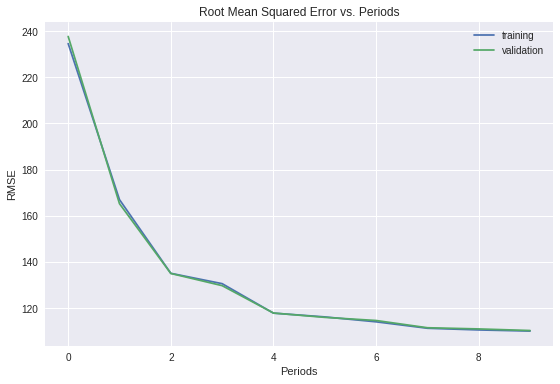

In [35]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.01,
    steps=500,
    batch_size=10,
    hidden_units=[10, 2],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 106.17
  period 01 : 103.15
  period 02 : 101.70
  period 03 : 98.73
  period 04 : 96.91
  period 05 : 95.84
  period 06 : 94.06
  period 07 : 97.99
  period 08 : 92.35
  period 09 : 93.64
Model training finished.
Final RMSE (on training data):   93.64
Final RMSE (on validation data): 95.71


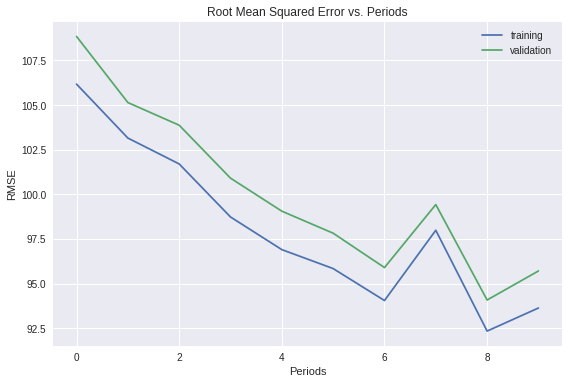

In [36]:
#更优的参数
dnn_regressor = train_nn_regression_model(
    learning_rate=0.001,
    steps=2000,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

## 任务二：用测试数据进行评估

In [0]:
california_housing_test_data = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_test.csv", sep=",")

In [38]:
test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)

predict_testing_input_fn = lambda: my_input_fn(test_examples, 
                                               test_targets["median_house_value"], 
                                               num_epochs=1, 
                                               shuffle=False)

test_predictions = dnn_regressor.predict(input_fn=predict_testing_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))

print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

Final RMSE (on test data): 91.91
